Dizi uzunluğu: 512
t dizisi: [0.000000, 0.000001, ..., 0.000511] saniye
t dizisi boyutu: (512,)

Chirp dizisi:
  Boyut: (512,)
  Tip: complex128
  İlk 3 eleman: [1.        +0.j         0.33688985+0.94154407j 0.19509032-0.98078528j]
  chirp[0] = 1.0000+0.0000j  ← t=0'daki karmaşık sayı
  chirp[1] = 0.3369+0.9415j  ← t=1'deki karmaşık sayı
  chirp[2] = 0.1951-0.9808j  ← t=2'deki karmaşık sayı

Alınan sinyal:
  Hedef mesafesi: 200 m
  Gecikme: 1.333 μs
  Kaç örnek kaydı: 1
  Boyut: (512,)
  İlk 3 eleman (önce sıfır, sonra başlıyor):
  [0.        +0.j         1.        +0.j         0.33688985+0.94154407j]

FFT sonrası:
  S boyutu: (512,)  (received'ın FFT'si)
  H boyutu: (512,)  (chirp'in FFT'si)
  S × conj(H) boyutu: (512,)
  IFFT çıkışı boyutu: (512,)

SONUÇ:
  Peak indeksi: 1
  Bulunan mesafe: 150.0 m
  Gerçek mesafe:  200 m


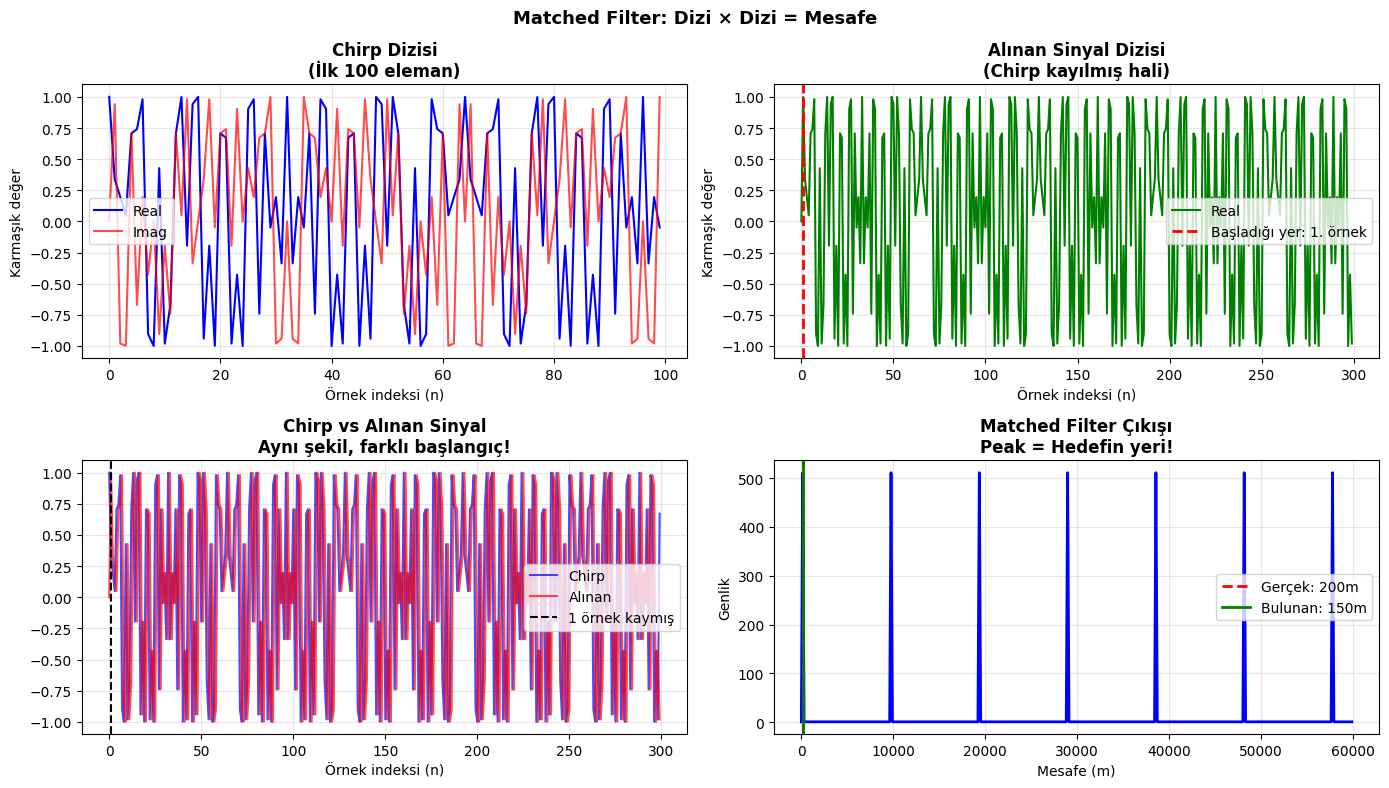

'\n\n---\n\n## Özet: Tek Cümlede\n```\nChirp    = [z0, z1, z2, ..., z1023]  → 1024 elemanlı dizi\nReceived = [z0, z1, z2, ..., z1023]  → 1024 elemanlı dizi\n\nFFT(received) × conj(FFT(chirp))     → 1024 elemanlı dizi\n\nIFFT(sonuç)                          → 1024 elemanlı dizi\n                                        Peak neredeyse\n                                        hedef orada!\n'

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# ============================================
# Her şey N=512 uzunluğunda bir dizi
# ============================================
N = 512
fs = 1e6          # 1 MHz örnekleme
T = N / fs        # Toplam süre
K = 200e6 / T     # Chirp rate
t = np.arange(N) / fs

print(f"Dizi uzunluğu: {N}")
print(f"t dizisi: [{t[0]:.6f}, {t[1]:.6f}, ..., {t[-1]:.6f}] saniye")
print(f"t dizisi boyutu: {t.shape}")

# ============================================
# ADIM 1: Chirp dizisi oluştur
# Her eleman = o andaki karmaşık voltaj
# ============================================
chirp = np.exp(1j * np.pi * K * t**2)

print(f"\nChirp dizisi:")
print(f"  Boyut: {chirp.shape}")
print(f"  Tip: {chirp.dtype}")
print(f"  İlk 3 eleman: {chirp[:3]}")
print(f"  chirp[0] = {chirp[0]:.4f}  ← t=0'daki karmaşık sayı")
print(f"  chirp[1] = {chirp[1]:.4f}  ← t=1'deki karmaşık sayı")
print(f"  chirp[2] = {chirp[2]:.4f}  ← t=2'deki karmaşık sayı")

# ============================================
# ADIM 2: Alınan sinyal dizisi
# Hedef 200m uzakta → gecikme var
# ============================================
R_hedef = 200
delay = 2 * R_hedef / 3e8        # saniye cinsinden gecikme
delay_samples = int(delay * fs)   # kaç örnek kaydı?

print(f"\nAlınan sinyal:")
print(f"  Hedef mesafesi: {R_hedef} m")
print(f"  Gecikme: {delay*1e6:.3f} μs")
print(f"  Kaç örnek kaydı: {delay_samples}")

# Alınan sinyal = chirp ama delay_samples kadar kaymış
received = np.zeros(N, dtype=complex)
received[delay_samples:] = chirp[:N - delay_samples]

print(f"  Boyut: {received.shape}")
print(f"  İlk {delay_samples+2} eleman (önce sıfır, sonra başlıyor):")
print(f"  {received[:delay_samples+2]}")

# ============================================
# ADIM 3: Matched Filter
# received ve chirp dizileri FFT ile karşılaştırılır
# ============================================

# 3a. İki diziyi de FFT'ye sok
S = np.fft.fft(received)   # N elemanlı dizi → N elemanlı dizi
H = np.fft.fft(chirp)      # N elemanlı dizi → N elemanlı dizi

print(f"\nFFT sonrası:")
print(f"  S boyutu: {S.shape}  (received'ın FFT'si)")
print(f"  H boyutu: {H.shape}  (chirp'in FFT'si)")

# 3b. Eleman eleman çarp (dizi × dizi = dizi)
product = S * np.conj(H)   # N elemanlı dizi

print(f"  S × conj(H) boyutu: {product.shape}")

# 3c. IFFT ile zaman domenine dön
output = np.fft.ifft(product)  # N elemanlı dizi

print(f"  IFFT çıkışı boyutu: {output.shape}")

# ============================================
# SONUÇ
# ============================================
range_axis = np.arange(N) * 3e8 / (2 * fs)

peak_idx = np.argmax(np.abs(output))
found_range = range_axis[peak_idx]

print(f"\nSONUÇ:")
print(f"  Peak indeksi: {peak_idx}")
print(f"  Bulunan mesafe: {found_range:.1f} m")
print(f"  Gerçek mesafe:  {R_hedef} m")

# ============================================
# GÖRSELLEŞTİRME
# ============================================
fig, axes = plt.subplots(2, 2, figsize=(14, 8))

# Chirp dizisi
ax = axes[0, 0]
ax.plot(range(100), np.real(chirp[:100]), 'b-', linewidth=1.5, label='Real')
ax.plot(range(100), np.imag(chirp[:100]), 'r-', linewidth=1.5, 
        alpha=0.7, label='Imag')
ax.set_title('Chirp Dizisi\n(İlk 100 eleman)', fontweight='bold')
ax.set_xlabel('Örnek indeksi (n)')
ax.set_ylabel('Karmaşık değer')
ax.legend()
ax.grid(True, alpha=0.3)

# Alınan sinyal dizisi
ax = axes[0, 1]
ax.plot(range(300), np.real(received[:300]), 'g-', linewidth=1.5, label='Real')
ax.axvline(delay_samples, color='r', linestyle='--', linewidth=2,
           label=f'Başladığı yer: {delay_samples}. örnek')
ax.set_title('Alınan Sinyal Dizisi\n(Chirp kayılmış hali)', fontweight='bold')
ax.set_xlabel('Örnek indeksi (n)')
ax.set_ylabel('Karmaşık değer')
ax.legend()
ax.grid(True, alpha=0.3)

# İki diziyi üst üste koy
ax = axes[1, 0]
ax.plot(range(300), np.real(chirp[:300]), 'b-', 
        linewidth=1.5, alpha=0.7, label='Chirp')
ax.plot(range(300), np.real(received[:300]), 'r-', 
        linewidth=1.5, alpha=0.7, label='Alınan')
ax.axvline(delay_samples, color='k', linestyle='--',
           label=f'{delay_samples} örnek kaymış')
ax.set_title('Chirp vs Alınan Sinyal\nAynı şekil, farklı başlangıç!', 
             fontweight='bold')
ax.set_xlabel('Örnek indeksi (n)')
ax.legend()
ax.grid(True, alpha=0.3)

# Matched filter çıkışı
ax = axes[1, 1]
ax.plot(range_axis[:400], np.abs(output[:400]), 'b-', linewidth=2)
ax.axvline(R_hedef, color='r', linestyle='--', linewidth=2,
           label=f'Gerçek: {R_hedef}m')
ax.axvline(found_range, color='g', linestyle='-', linewidth=2,
           label=f'Bulunan: {found_range:.0f}m')
ax.set_title('Matched Filter Çıkışı\nPeak = Hedefin yeri!', fontweight='bold')
ax.set_xlabel('Mesafe (m)')
ax.set_ylabel('Genlik')
ax.legend()
ax.grid(True, alpha=0.3)

plt.suptitle('Matched Filter: Dizi × Dizi = Mesafe', 
             fontsize=13, fontweight='bold')
plt.tight_layout()
plt.show()

"""

---

## Özet: Tek Cümlede
```
Chirp    = [z0, z1, z2, ..., z1023]  → 1024 elemanlı dizi
Received = [z0, z1, z2, ..., z1023]  → 1024 elemanlı dizi

FFT(received) × conj(FFT(chirp))     → 1024 elemanlı dizi

IFFT(sonuç)                          → 1024 elemanlı dizi
                                        Peak neredeyse
                                        hedef orada!
"""